# Introduction to Redundancy Analysis (RDA) and Canonical Correspondence Analysis (CCA)

Redundancy Analysis (RDA) is a direct extension of multiple regression, allowing for the modeling of the effect of an explanatory matrix \(X\) (n x p), such as diet and demographic factors, on a response matrix \(Y\) (n x m), such as Operational Taxonomic Units (OTUs). Unlike traditional multiple regression, which models the effect on a single response variable, RDA models the effect on an entire response matrix. This is achieved by performing an ordination of \(Y\) to obtain axes that are linear combinations of the variables in \(X\). The explanatory variables in \(X\) can be quantitative, qualitative, or binary, and should be centered, standardized, transformed, or normalized as appropriate. Collinearity among \(X\) variables should be minimized before conducting RDA. Ecological reasoning should guide the selection of variables, supplemented by forward, backward, or stepwise selection if necessary to address non-significance or collinearity.

Canonical Correspondence Analysis (CCA) is similar to RDA but is specifically designed for ecological data where species responses, represented by OTUs, are unimodal rather than linear. CCA directly relates species composition to environmental gradients, such as diet and demographic factors, by constraining the ordination of species data by these explanatory variables. This makes CCA particularly useful for studying ecological relationships where OTUs have specific optimal conditions along environmental gradients. Like RDA, the explanatory variables in \(X\) need to be appropriately processed to ensure accurate and meaningful results.


In [1]:
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('vegan')

R[write to console]: trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-x86_64/contrib/4.4/vegan_2.6-6.1.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3174160 bytes (3.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con


The downloaded binary packages are in
	/var/folders/32/t2nvddws3m1_b8yxvknv_c_c0000gn/T//RtmpwBRu7k/downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x10ea40110> [0]

# Data Preprocessing and Multicollinearity Analysis

This script preprocess a dataset by converting categorical variables to dummy variables, handling missing values, standardizing the data, and checking for multicollinearity using Variance Inflation Factor (VIF) and correlation analysis.

Steps include:
1. **Loading Data**: Load the dataset from an Excel file.
2. **Categorical Conversion**: Convert specified categorical columns to dummy variables to avoid multicollinearity.
3. **Numeric Conversion**: Ensure specific columns are numeric, handling conversion errors.
4. **Missing Value Imputation**: Fill missing values with the mean of each column.
5. **Standardization**: Standardize numeric data.
6. **Variable Selection**: Subset the data with the most important variables.
7. **VIF Calculation**: Calculate VIF for each variable to check for multicollinearity.
8. **Correlation Analysis**: Identify highly correlated pairs of variables.


In [70]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Load DataFrame
mdata = pd.read_excel('/Users/nijat/Downloads/metadata.xlsx')

# Convert categorical columns to dummy variables
categorical_columns = ['Ethnicity', 'Marriage', 'Gender', 'GroupAs']
for column in categorical_columns:
    dummies = pd.get_dummies(mdata[column], prefix=column, drop_first=True)
    mdata = pd.concat([mdata, dummies], axis=1)
    mdata.drop(column, axis=1, inplace=True)

# Convert specified columns to numeric
columns_to_convert = {
    'Age', 'Income', 'BaPHQ8', 'BaFCP', 'BAtotalMDS', 'Immuno', 'F_TOTAL', 'V_TOTAL', 
    'G_TOTAL', 'PF_TOTAL', 'D_TOTAL', 'FIBEg1000', 'IRONg1000', 'SODIg1000', 'ZINCg1000', 
    'FOLAg1000', 'VITDg1000', 'ModerationHEI', 'Steroids', 'AntiTNF', 'BaBMI'
}
for col in columns_to_convert:
    mdata[col] = pd.to_numeric(mdata[col], errors='coerce')

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
mdata[list(columns_to_convert)] = imputer.fit_transform(mdata[list(columns_to_convert)])

# Standardize numeric data
scaler = StandardScaler()
mdata[list(columns_to_convert)] = scaler.fit_transform(mdata[list(columns_to_convert)])

# Subset data with the most important variables
subset_data = mdata[list(columns_to_convert)]

# Add a constant to the model
X = add_constant(subset_data)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF Data:")
print(vif_data)

# Calculate and display highly correlated pairs
cor_matrix = X.corr()
corr_stack = cor_matrix.abs().stack().reset_index()
corr_stack.columns = ['Variable1', 'Variable2', 'Correlation']
highly_correlated_pairs = corr_stack[(corr_stack['Variable1'] != corr_stack['Variable2']) & 
                                     (corr_stack['Correlation'] > 0.8)]
print("Highly Correlated Pairs:")
print(highly_correlated_pairs)



VIF Data:
          Feature       VIF
0           const  1.000000
1       ZINCg1000  9.155530
2       FOLAg1000  4.432213
3          Income  3.213393
4        PF_TOTAL  3.975087
5           BaFCP  4.274504
6         V_TOTAL  5.782519
7         F_TOTAL  4.367713
8          BaPHQ8  3.271586
9      BAtotalMDS  5.742231
10        D_TOTAL  3.874846
11        G_TOTAL  3.595167
12      FIBEg1000  7.021740
13            Age  3.268915
14      SODIg1000  7.030757
15         Immuno  3.221950
16       Steroids  3.444780
17      IRONg1000  9.237054
18          BaBMI  3.774036
19      VITDg1000  2.607074
20        AntiTNF  2.244048
21  ModerationHEI  5.436296
Highly Correlated Pairs:
Empty DataFrame
Columns: [Variable1, Variable2, Correlation]
Index: []


# Methods

Microbiome data were obtained from a tab-delimited text file and diet data from an Excel file. The diet data was indexed by UCSID and merged with microbiome data, pivoted by OTUs. Numeric variables were converted to numeric types and categorical variables to categorical types. Missing values in numeric variables were imputed using the median, and the data were standardized using the StandardScaler. The processed data were converted to R data frames and analyzed using distance-based canonical analysis (db-CCA) with the Bray-Curtis distance measure in R. Significance tests were performed, and variance explained and adjusted R-squared values were calculated. The results included loadings of OTUs on significant axes and environmental scores.


In [71]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects

# Load data
microbiome_data = pd.read_csv('/Users/nijat/Downloads/mappedTaxa.txt', delimiter='\t')
diet_data = pd.read_excel('/Users/nijat/Downloads/metadata.xlsx')

# Set index
diet_data.set_index('UCSID', inplace=True)

# Pivot microbiome data
microbiome_pivot = microbiome_data.pivot_table(index='Sample', columns='OTU', values='value', fill_value=0)

# Important variables
variables = [
    'Age', 'Income', 'BaPHQ8', 'BaFCP', 'BAtotalMDS', 'Immuno', 'F_TOTAL', 'V_TOTAL', 
    'G_TOTAL', 'PF_TOTAL', 'D_TOTAL', 'FIBEg1000', 'IRONg1000', 'SODIg1000', 'ZINCg1000', 
    'FOLAg1000', 'VITDg1000', 'ModerationHEI', 'Steroids', 'AntiTNF', 'BaBMI'
]

# Merge dataframes
combined_data = pd.merge(microbiome_pivot, diet_data[variables + ['GroupAs']], left_index=True, right_index=True, how='inner')

# Remove missing data
combined_data.dropna(inplace=True)

# Split data
response_data = combined_data.drop(columns=variables + ['GroupAs'])
explanatory_data = combined_data[variables]
group_data = combined_data['GroupAs']

# Remove all-zero rows
nonzero_rows = (response_data.T != 0).any()
response_data = response_data[nonzero_rows]
explanatory_data = explanatory_data[nonzero_rows]
group_data = group_data[nonzero_rows]

# Convert to numeric
explanatory_data = explanatory_data.apply(pd.to_numeric, errors='coerce')

# Impute missing values
imputer = SimpleImputer(strategy='median')
explanatory_data = pd.DataFrame(imputer.fit_transform(explanatory_data), columns=explanatory_data.columns)

# Normalize data
scaler = StandardScaler()
explanatory_data = pd.DataFrame(scaler.fit_transform(explanatory_data), columns=explanatory_data.columns)

# R conversion
pandas2ri.activate()
response_data = response_data.apply(pd.to_numeric, errors='coerce').reset_index(drop=True)
explanatory_data = explanatory_data.apply(pd.to_numeric, errors='coerce').reset_index(drop=True)
group_data = group_data.reset_index(drop=True)

# Convert to R DataFrames
r_response_data = pandas2ri.py2rpy(response_data)
r_explanatory_data = pandas2ri.py2rpy(explanatory_data)
r_group_data = pandas2ri.py2rpy(group_data)

# Assign to R environment
robjects.globalenv['response_data'] = r_response_data
robjects.globalenv['explanatory_data'] = r_explanatory_data
robjects.globalenv['group_data'] = r_group_data

# Perform db-CCA in R
result = robjects.r('''
library(vegan)
response_data_001 <- response_data + 0.001
dbCCA <- capscale(response_data_001 ~ ., data = explanatory_data, dist = "bray")
anova_result <- anova.cca(dbCCA)
anova_terms_result <- anova.cca(dbCCA, by = "terms", permu = 1000)
variance_explained <- summary(dbCCA)$cont$importance[2, ]
r_squared <- RsquareAdj(dbCCA)$r.squared
adj_r_squared <- RsquareAdj(dbCCA)$adj.r.squared
ordered_anova_terms_result <- anova_terms_result[order(anova_terms_result$'Pr(>F)'), ]
list(
  anova_result = anova_result,
  anova_terms_result = ordered_anova_terms_result,
  variance_explained = variance_explained,
  r_squared = r_squared,
  adj_r_squared = adj_r_squared
)
''')

# Extract and print results
anova_result = result.rx2('anova_result')
anova_terms_result = result.rx2('anova_terms_result')
variance_explained = result.rx2('variance_explained')
r_squared = result.rx2('r_squared')
adj_r_squared = result.rx2('adj_r_squared')

print("Overall Significance Test:")
print(anova_result)

anova_terms_df = pd.DataFrame(robjects.conversion.rpy2py(anova_terms_result))
print("\nPermutation Tests for Individual Environmental Variables (ordered by significance):")
print(anova_terms_df)

print("\nOverall Variance Explained by Canonical Axes:")
print(variance_explained)

print("\nR-squared:")
print(r_squared)

print("\nAdjusted R-squared:")
print(adj_r_squared)



Overall Significance Test:
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = response_data_001 ~ Age + Income + BaPHQ8 + BaFCP + BAtotalMDS + Immuno + F_TOTAL + V_TOTAL + G_TOTAL + PF_TOTAL + D_TOTAL + FIBEg1000 + IRONg1000 + SODIg1000 + ZINCg1000 + FOLAg1000 + VITDg1000 + ModerationHEI + Steroids + AntiTNF + BaBMI, data = explanatory_data, distance = "bray")
         Df SumOfSqs      F Pr(>F)
Model    21   5.5872 1.1112  0.258
Residual  5   1.1971              


Permutation Tests for Individual Environmental Variables (ordered by significance):
                Df  SumOfSqs         F  Pr(>F)
BaPHQ8         1.0  0.563966  2.355487   0.002
Immuno         1.0  0.430359  1.797457   0.030
Age            1.0  0.376207  1.571284   0.058
Income         1.0  0.384868  1.607456   0.058
G_TOTAL        1.0  0.372522  1.555891   0.066
SODIg1000      1.0  0.329330  1.375493   0.143
V_TOTAL        1.0  0.320729  1.339570   0.15

In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

# Load data
microbiome_data = pd.read_csv('/Users/nijat/Downloads/mappedTaxa.txt', delimiter='\t')
diet_data = pd.read_excel('/Users/nijat/Downloads/metadata.xlsx')

# Ensure UCSID is set as the index in diet_data
diet_data.set_index('UCSID', inplace=True)

# Prepare microbiome data
microbiome_pivot = microbiome_data.pivot_table(index='Sample', columns='OTU', values='value', fill_value=0)

# Define variables
numeric_variables = ['Age', 'Income', 'BaPHQ8', 'BaFCP', 'Immuno', 'G_TOTAL']
categorical_variables = ['Gender', 'GroupAs']

# Convert specified columns to numeric where applicable
for col in numeric_variables:
    diet_data[col] = pd.to_numeric(diet_data[col], errors='coerce')

# Merge dataframes on Sample and UCSID
combined_data = pd.merge(microbiome_pivot, diet_data[numeric_variables + categorical_variables], left_index=True, right_index=True, how='inner')

# Remove rows with any missing data
combined_data = combined_data.dropna()

# Split combined data into response and explanatory variables
response_data = combined_data.drop(columns=numeric_variables + categorical_variables)
explanatory_data = combined_data[numeric_variables + categorical_variables]

# Remove rows with all zeros in response_data
nonzero_rows = (response_data.T != 0).any()
response_data = response_data[nonzero_rows]
explanatory_data = explanatory_data[nonzero_rows]

# Convert categorical variables to category dtype
for col in categorical_variables:
    explanatory_data[col] = explanatory_data[col].astype('category')

# Impute missing values (NaNs) with the mean for numeric variables
imputer = SimpleImputer(strategy='median')
explanatory_data_imputed = explanatory_data.copy()
explanatory_data_imputed[numeric_variables] = imputer.fit_transform(explanatory_data[numeric_variables])

# Normalize (standardize) numeric explanatory variables
scaler = StandardScaler()
explanatory_data_scaled = explanatory_data_imputed.copy()
explanatory_data_scaled[numeric_variables] = scaler.fit_transform(explanatory_data_imputed[numeric_variables])

# Initialize R conversion
pandas2ri.activate()

# Ensure all data is numeric and reset the index to maintain DataFrame structure
response_data = response_data.apply(pd.to_numeric, errors='coerce').reset_index(drop=True)
explanatory_data_scaled = explanatory_data_scaled.apply(pd.to_numeric, errors='coerce').reset_index(drop=True)

# Convert DataFrames to R DataFrames
r_response_data = pandas2ri.py2rpy(response_data)
r_explanatory_data = pandas2ri.py2rpy(explanatory_data_scaled)

# Assign DataFrames to R global environment
robjects.globalenv['response_data'] = r_response_data
robjects.globalenv['explanatory_data'] = r_explanatory_data

# Perform db-RDA in R and extract results
result = robjects.r('''
library(vegan)

# Add a small constant to avoid zero values
response_data_001 <- response_data + 0.001

# Perform db-RDA using the Bray-Curtis distance measure
dbRDA <- capscale(response_data_001 ~ ., data = explanatory_data, dist = "bray")

# Extract the loadings of the OTUs on the significant axes
loadings <- scores(dbRDA, display = "species")

# Extract the environmental scores
env_scores <- scores(dbRDA, display = "bp")

# Perform overall significance test
anova_result <- anova(dbRDA)

# Perform permutation tests for individual environmental variables
anova_terms_result <- anova(dbRDA, by = "terms", permu = 1000)

# Calculate the variance explained
variance_explained <- summary(dbRDA)$cont$importance[2, ]

# Calculate adjusted R-squared values
r_squared <- RsquareAdj(dbRDA)$r.squared
adj_r_squared <- RsquareAdj(dbRDA)$adj.r.squared

# Return the results and scores
list(
  anova_result = anova_result,
  anova_terms_result = anova_terms_result,
  variance_explained = variance_explained,
  r_squared = r_squared,
  adj_r_squared = adj_r_squared,
  loadings = as.data.frame(loadings),
  env_scores = as.data.frame(env_scores)
)
''')

# Extract results
anova_result = result.rx2('anova_result')
anova_terms_result = result.rx2('anova_terms_result')
variance_explained = result.rx2('variance_explained')
r_squared = result.rx2('r_squared')
adj_r_squared = result.rx2('adj_r_squared')
loadings = result.rx2('loadings')
env_scores = result.rx2('env_scores')

# Convert R data frames to Pandas DataFrames
loadings_df = pandas2ri.rpy2py(loadings)
env_scores_df = pandas2ri.rpy2py(env_scores)

# Function to find top 10 OTUs for each axis
def find_top_otus(axis, n=10):
    return loadings_df[axis].abs().sort_values(ascending=False).head(n).index

# Find top 10 OTUs for CAP1 and CAP2
top_otus_cap1 = find_top_otus('CAP1')
top_otus_cap2 = find_top_otus('CAP2')

# Create DataFrames for the top OTUs
df_top_otus_cap1 = loadings_df.loc[top_otus_cap1, ['CAP1']]
df_top_otus_cap2 = loadings_df.loc[top_otus_cap2, ['CAP2']]

# Display the DataFrames
print("Top OTUs for CAP1:")
print(df_top_otus_cap1)

print("\nTop OTUs for CAP2:")
print(df_top_otus_cap2)

# Display overall results
print("Overall Significance Test:")
print(anova_result)

print("\nPermutation Tests for Individual Environmental Variables:")
print(anova_terms_result)

print("\nVariance Explained:")
print(variance_explained)

print("\nR-squared:")
print(r_squared)

print("\nAdjusted R-squared:")
print(adj_r_squared)


Top OTUs for CAP1:
                                                        CAP1
g__Blautia.s__Blautia_wexlerae                     -0.658612
g__Blautia.s__Ruminococcus_gnavus                  -0.357415
g__Blautia.s__Blautia_sp_CAG_257                   -0.356861
g__Erysipelatoclostridium.s__Clostridium_innocuum  -0.305181
g__Bifidobacterium.s__Bifidobacterium_adolescentis  0.260313
g__Anaerostipes.s__Anaerostipes_hadrus              0.234142
g__Faecalibacterium.s__Faecalibacterium_prausni...  0.230572
g__Dorea.s__Dorea_sp_CAG_317                       -0.223657
g__Ruminococcus.s__Ruminococcus_bromii             -0.219367
g__Holdemanella.s__Holdemanella_biformis            0.215322

Top OTUs for CAP2:
                                                        CAP2
g__Roseburia.s__Roseburia_faecis                   -0.354095
g__Anaerostipes.s__Anaerostipes_hadrus              0.344102
g__Blautia.s__Ruminococcus_torques                  0.306491
g__Bifidobacterium.s__Bifidobacterium_adolesce

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In screeplot.cca(dbCCA, bstick = TRUE) :
R[write to console]: 
 
R[write to console]:  'bstick' unavailable for constrained ordination



Top OTUs for CAP1:
                                                        CAP1
g__Blautia.s__Blautia_wexlerae                     -0.658612
g__Blautia.s__Ruminococcus_gnavus                  -0.357415
g__Blautia.s__Blautia_sp_CAG_257                   -0.356861
g__Erysipelatoclostridium.s__Clostridium_innocuum  -0.305181
g__Bifidobacterium.s__Bifidobacterium_adolescentis  0.260313
g__Anaerostipes.s__Anaerostipes_hadrus              0.234142
g__Faecalibacterium.s__Faecalibacterium_prausni...  0.230572
g__Dorea.s__Dorea_sp_CAG_317                       -0.223657
g__Ruminococcus.s__Ruminococcus_bromii             -0.219367
g__Holdemanella.s__Holdemanella_biformis            0.215322
g__Dorea.s__Dorea_longicatena                       0.199602
g__Blautia.s__Blautia_hansenii                     -0.198096
g__Blautia.s__Ruminococcus_torques                  0.178864
g__Bifidobacterium.s__Bifidobacterium_animalis     -0.160986
g__Fusicatenibacter.s__Fusicatenibacter_sacchar...  0.126319
g__Ak

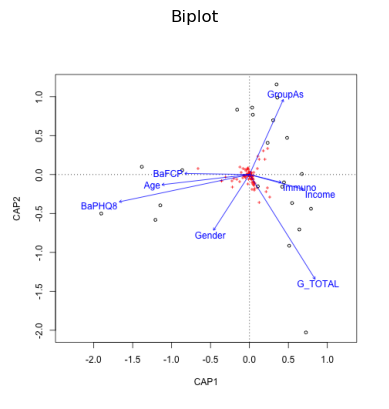

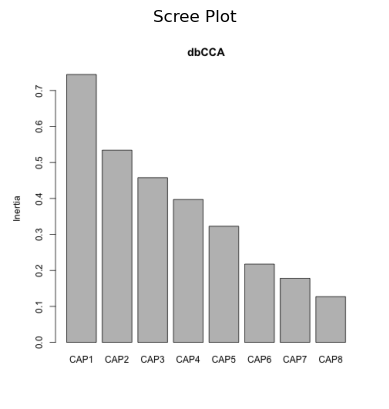

In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
import matplotlib.pyplot as plt

# Load data
microbiome_data = pd.read_csv('/Users/nijat/Downloads/mappedTaxa.txt', delimiter='\t')
diet_data = pd.read_excel('/Users/nijat/Downloads/metadata.xlsx')

# Ensure UCSID is set as the index in diet_data
diet_data.set_index('UCSID', inplace=True)

# Prepare microbiome data
microbiome_pivot = microbiome_data.pivot_table(index='Sample', columns='OTU', values='value', fill_value=0)

# Define variables
numeric_variables = ['Age', 'Income', 'BaPHQ8', 'BaFCP', 'Immuno', 'G_TOTAL']
categorical_variables = ['Gender', 'GroupAs']

# Convert specified columns to numeric where applicable
for col in numeric_variables:
    diet_data[col] = pd.to_numeric(diet_data[col], errors='coerce')

# Merge dataframes on Sample and UCSID
combined_data = pd.merge(microbiome_pivot, diet_data[numeric_variables + categorical_variables], left_index=True, right_index=True, how='inner')

# Remove rows with any missing data
combined_data = combined_data.dropna()

# Split combined data into response and explanatory variables
response_data = combined_data.drop(columns=numeric_variables + categorical_variables)
explanatory_data = combined_data[numeric_variables + categorical_variables]

# Remove rows with all zeros in response_data
nonzero_rows = (response_data.T != 0).any()
response_data = response_data[nonzero_rows]
explanatory_data = explanatory_data[nonzero_rows]

# Convert categorical variables to category dtype
for col in categorical_variables:
    explanatory_data[col] = explanatory_data[col].astype('category')

# Impute missing values (NaNs) with the mean for numeric variables
imputer = SimpleImputer(strategy='median')
explanatory_data_imputed = explanatory_data.copy()
explanatory_data_imputed[numeric_variables] = imputer.fit_transform(explanatory_data[numeric_variables])

# Normalize (standardize) numeric explanatory variables
scaler = StandardScaler()
explanatory_data_scaled = explanatory_data_imputed.copy()
explanatory_data_scaled[numeric_variables] = scaler.fit_transform(explanatory_data_imputed[numeric_variables])

# Initialize R conversion
pandas2ri.activate()

# Ensure all data is numeric and reset the index to maintain DataFrame structure
response_data = response_data.apply(pd.to_numeric, errors='coerce').reset_index(drop=True)
explanatory_data_scaled = explanatory_data_scaled.apply(pd.to_numeric, errors='coerce').reset_index(drop=True)

# Convert DataFrames to R DataFrames
r_response_data = pandas2ri.py2rpy(response_data)
r_explanatory_data = pandas2ri.py2rpy(explanatory_data_scaled)

# Assign DataFrames to R global environment
robjects.globalenv['response_data'] = r_response_data
robjects.globalenv['explanatory_data'] = r_explanatory_data

# Perform db-CCA in R and extract results
result = robjects.r('''
library(vegan)

# Add a small constant to avoid zero values
response_data_001 <- response_data + 0.001

# Perform db-CCA using the Bray-Curtis distance measure
dbCCA <- capscale(response_data_001 ~ ., data = explanatory_data, dist = "bray")

# Extract the loadings of the OTUs on the significant axes
loadings <- scores(dbCCA, display = "species")

# Extract the environmental scores
env_scores <- scores(dbCCA, display = "bp")

# Perform overall significance test
anova_result <- anova.cca(dbCCA)

# Perform permutation tests for individual environmental variables
anova_terms_result <- anova.cca(dbCCA, by = "terms", permu = 1000)

# Calculate the variance explained
variance_explained <- summary(dbCCA)$cont$importance[2, ]

# Calculate adjusted R-squared values
r_squared <- RsquareAdj(dbCCA)$r.squared
adj_r_squared <- RsquareAdj(dbCCA)$adj.r.squared

# Save biplot
png(filename="biplot.png")
plot(dbCCA)
dev.off()

# Save scree plot
png(filename="screeplot.png")
screeplot(dbCCA, bstick = TRUE)
dev.off()

# Return the results and scores
list(
  anova_result = anova_result,
  anova_terms_result = anova_terms_result,
  variance_explained = variance_explained,
  r_squared = r_squared,
  adj_r_squared = adj_r_squared,
  loadings = as.data.frame(loadings),
  env_scores = as.data.frame(env_scores)
)
''')

# Extract results
anova_result = result.rx2('anova_result')
anova_terms_result = result.rx2('anova_terms_result')
variance_explained = result.rx2('variance_explained')
r_squared = result.rx2('r_squared')
adj_r_squared = result.rx2('adj_r_squared')
loadings = result.rx2('loadings')
env_scores = result.rx2('env_scores')

# Convert R data frames to Pandas DataFrames
loadings_df = pandas2ri.rpy2py(loadings)
env_scores_df = pandas2ri.rpy2py(env_scores)

# Function to find top 10 OTUs for each axis
def find_top_otus(axis, n=20):
    return loadings_df[axis].abs().sort_values(ascending=False).head(n).index

# Find top 10 OTUs for CAP1 and CAP2
top_otus_cap1 = find_top_otus('CAP1')
top_otus_cap2 = find_top_otus('CAP2')

# Create DataFrames for the top OTUs
df_top_otus_cap1 = loadings_df.loc[top_otus_cap1, ['CAP1']]
df_top_otus_cap2 = loadings_df.loc[top_otus_cap2, ['CAP2']]

# Display the DataFrames
print("Top OTUs for CAP1:")
print(df_top_otus_cap1)

print("\nTop OTUs for CAP2:")
print(df_top_otus_cap2)

# Display overall results
print("Overall Significance Test:")
print(anova_result)

print("\nPermutation Tests for Individual Environmental Variables:")
print(anova_terms_result)

print("\nVariance Explained:")
print(variance_explained)

print("\nR-squared:")
print(r_squared)

print("\nAdjusted R-squared:")
print(adj_r_squared)

# Display plots
biplot_img = plt.imread('biplot.png')
plt.imshow(biplot_img)
plt.axis('off')
plt.title('Biplot')
plt.show()

screeplot_img = plt.imread('screeplot.png')
plt.imshow(screeplot_img)
plt.axis('off')
plt.title('Scree Plot')
plt.show()
